# JobSeekerAgency: an Agentic Workflow to make the whole process of find your next dream job effortless

In [1]:
import sys
sys.path.append('../python')
sys.path.append('../../keys')

In [2]:
%load_ext autoreload
%autoreload 2

import os
from langchain.prompts import (
    PromptTemplate,
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.schema import Document
from langchain_core.messages import ToolMessage, BaseMessage, AIMessage, HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langchain.document_loaders import WikipediaLoader

from langchain.document_loaders import CSVLoader

# chains
from langchain.chains import LLMChain, SequentialChain, SimpleSequentialChain, RouterChain, TransformChain
from langchain.chains.router import MultiPromptChain
from langchain.chains.router.multi_prompt_prompt import MULTI_PROMPT_ROUTER_TEMPLATE
from langchain.chains.router.llm_router import LLMRouterChain,RouterOutputParser

# memory
from langchain.memory import ChatMessageHistory, ConversationBufferMemory, ConversationBufferWindowMemory, ConversationSummaryBufferMemory
from langchain.chains import ConversationChain
import pickle
# Agents
from langchain.agents import load_tools, initialize_agent, AgentType, tool

# RAG
import chromadb
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain.document_loaders import TextLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

## LangGraph
from pydantic import BaseModel, Field
from typing import List,Sequence,TypedDict,Annotated,Literal
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from operator import add
from langgraph.checkpoint.memory import MemorySaver, InMemorySaver

## Visualize the graph:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

## OpenAI
from openai import OpenAI 

## Custom scripts:
import Constants as C

import warnings
warnings.filterwarnings("ignore")

In [3]:
os.environ['OPENAI_API_KEY'] = C.OPENAI_API_KEY
os.environ['SERPAPI_API_KEY'] = C.SERPAPI_API_KEY # make sure it spelled as: SERPAPI_API_KEY

## Functions

## Tools

In [4]:
@tool
def web_search_jobs_CH(company: str) -> str:
    """Use OpenAI's built-in web_search to find current jobs in Switzerland for a given company.
    Uses company name as input argument and returns a json formatted list"""
    
    # looks like the llm understands how to use the keyword as input
    query = f"site:{company.lower()}.com careers jobs Switzerland"
    print('> QUERY',query)
    resp = client.responses.create(
        model="gpt-4.1-mini",
        tools=[{"type": "web_search"}],
        input=f"Find ALL CURRENT job postings for {company} in Switzerland (Lausanne, Zurich, Basel and Bern) specifically using this domain: 'https://csl.wd1.myworkdayjobs.com/en-EN/CSL_External'. Return JSON list {{title, location, link}}."
    )
    output = f'Here are the current job postings for {company}: {resp.output_text}'
    # return resp.output_text
    return output

@tool
def coolest_guy(text:str) -> str:
    '''
    Returns the name of the coolest person in the universe.
    Expects an input of an empty string '' and returns the name of the coolest
    person in the universe
    '''
    return 'Jose Portilla'

## Main

In [25]:
# define your GPT chat model
client = OpenAI()
tools  = [web_search_jobs_CH,coolest_guy]
gpt    = ['gpt-4o-mini','gpt-5','gpt-5-nano'][1]
model  = ChatOpenAI(model=gpt,openai_api_key=os.environ['OPENAI_API_KEY'],temperature=0).bind_tools(tools)

In [26]:
class ChatMessages(TypedDict):
    messages: List[BaseMessage]
    question: HumanMessage # store the original question
    

def run_coder(state: ChatMessages):

    print('\n>> CALL MODEL>>\n')
    
    # define the system message
    system_message = SystemMessage(
        content="""You are an expert programmer that is ready to help write some clean and concise python code. Please ensure that:

        1. you use beautiful soup and async_playwright
        2. you only print/write python runnable code
        3. you end with with 'await main()' instead of 'asyncio.run(main())"""
    )
    
    if "messages" not in state or state["messages"] is None:
        print(">> REINITIALIZING MESSAGES STATE!!")
        state["messages"] = []
        state["messages"].append(state["question"])
        state["messages"].append(system_message)        

    messages = state['messages']
    prompt   = ChatPromptTemplate.from_messages(messages).format()
    response = model.invoke(prompt) # you are calling the llm here!
    state['messages'].append(response) # don't forget to add message to the response!
    print(state['messages'])
    return state

def should_continue(state) -> Literal['tools',END]:
    messages = state['messages']
    # print('\n>> Should continue:\n',messages)
    last_message = messages[-1]
    # check if the last message included a tool call from the agent!
    if last_message.tool_calls:
        print('\n>> calling tools\n')
        return "tools" # calls the tools node here
    return END

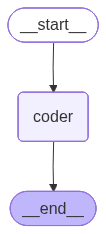

In [27]:
# tool_node = ToolNode(tools)

workflow = StateGraph(ChatMessages)

# Nodes
workflow.add_node('coder',run_coder)
# workflow.add_node('tools',tool_node)

# edges
workflow.add_edge(START,'coder')
# workflow.add_conditional_edges('coder',should_continue) # setting router function for the agent
# workflow.add_edge('tools','coder') # you want to link tools to agent because agent is responsible for giving an answer to human
# workflow.add_edge('agent',END)

checkpointer = MemorySaver() # set memory
graph = workflow.compile() # checkpointer=checkpointer
display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))

In [28]:
# %%time
company2careerpage = {
    'CSL':'https://csl.wd1.myworkdayjobs.com/en-EN/CSL_External?locationCountry=187134fccb084a0ea9b4b95f23890dbe',
    'Novartis':'https://www.novartis.com/careers/career-search?search_api_fulltext=data&country%5B0%5D=LOC_CH&field_job_posted_date=All&op=Submit&page=0',
    'VISIUM':'https://www.visium.com/join-us#open-positions',
    'LENOVO':'https://jobs.lenovo.com/en_US/careers/SearchJobs/?13036=%5B12016783%5D&13036_format=6621&listFilterMode=1&jobRecordsPerPage=10&',
    'AWS':'https://www.amazon.jobs/content/en/locations/switzerland/zurich?category%5B%5D=Solutions+Architect'
}
# 'Can you tell me who is the coolest guy in the univere?' # 
select     = 'CSL'
question   = f"""can you write a short python code to access this {select} career page ({company2careerpage[select]})?""" 

input_data = {"question": HumanMessage(content=question)}
res1       = graph.invoke(input=input_data, config={"configurable": {"thread_id": 1}})
res1['messages'][-1].content


>> CALL MODEL>>

>> REINITIALIZING MESSAGES STATE!!
[HumanMessage(content='can you write a short python code to access this CSL career page (https://csl.wd1.myworkdayjobs.com/en-EN/CSL_External?locationCountry=187134fccb084a0ea9b4b95f23890dbe)?', additional_kwargs={}, response_metadata={}), SystemMessage(content="You are an expert programmer that is ready to help write some clean and concise python code. Please ensure that:\n\n        1. you use beautiful soup and async_playwright\n        2. you only print/write python runnable code\n        3. you end with with 'await main()' instead of 'asyncio.run(main())", additional_kwargs={}, response_metadata={}), AIMessage(content='from bs4 import BeautifulSoup\nfrom urllib.parse import urljoin\nfrom playwright.async_api import async_playwright, TimeoutError as PlaywrightTimeoutError\n\nURL = "https://csl.wd1.myworkdayjobs.com/en-EN/CSL_External?locationCountry=187134fccb084a0ea9b4b95f23890dbe"\n\nasync def main():\n    async with async_playw

'from bs4 import BeautifulSoup\nfrom urllib.parse import urljoin\nfrom playwright.async_api import async_playwright, TimeoutError as PlaywrightTimeoutError\n\nURL = "https://csl.wd1.myworkdayjobs.com/en-EN/CSL_External?locationCountry=187134fccb084a0ea9b4b95f23890dbe"\n\nasync def main():\n    async with async_playwright() as p:\n        browser = await p.chromium.launch(headless=True)\n        context = await browser.new_context()\n        page = await context.new_page()\n        await page.goto(URL, wait_until="domcontentloaded")\n\n        await page.wait_for_selector("iframe")\n        target_frame = None\n        for f in page.frames:\n            if f != page.main_frame and "myworkdayjobs.com" in f.url:\n                target_frame = f\n                break\n        if target_frame is None:\n            frames = [f for f in page.frames if f != page.main_frame]\n            target_frame = frames[0] if frames else page.main_frame\n\n        try:\n            await target_frame.wa

In [30]:
print(res1['messages'][-1].content)

from bs4 import BeautifulSoup
from urllib.parse import urljoin
from playwright.async_api import async_playwright, TimeoutError as PlaywrightTimeoutError

URL = "https://csl.wd1.myworkdayjobs.com/en-EN/CSL_External?locationCountry=187134fccb084a0ea9b4b95f23890dbe"

async def main():
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        context = await browser.new_context()
        page = await context.new_page()
        await page.goto(URL, wait_until="domcontentloaded")

        await page.wait_for_selector("iframe")
        target_frame = None
        for f in page.frames:
            if f != page.main_frame and "myworkdayjobs.com" in f.url:
                target_frame = f
                break
        if target_frame is None:
            frames = [f for f in page.frames if f != page.main_frame]
            target_frame = frames[0] if frames else page.main_frame

        try:
            await target_frame.wait_for_selector('a[data-a

In [81]:
# web_search_jobs_CH('CSL')

In [200]:
# import ollama
# response = ollama.web_search("What is Ollama?")
# print(response)

#### CSL

In [33]:
import asyncio
from urllib.parse import urljoin
from bs4 import BeautifulSoup
from playwright.async_api import async_playwright

URL = "https://csl.wd1.myworkdayjobs.com/en-EN/CSL_External?locationCountry=187134fccb084a0ea9b4b95f23890dbe"

async def main():
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        context = await browser.new_context()
        page = await context.new_page()
        await page.goto(URL, wait_until="domcontentloaded")
        # Wait for job cards to render
        try:
            await page.wait_for_selector('a[data-automation-id="jobTitle"], a[data-automation-id="jobTitleLink"]', timeout=20000)
        except:
            pass
        html = await page.content()
        await browser.close()

    soup = BeautifulSoup(html, "html.parser")
    jobs = []
    for a in soup.select('a[data-automation-id="jobTitle"], a[data-automation-id="jobTitleLink"]'):
        title = a.get_text(strip=True)
        href = urljoin(URL, a.get("href") or "")
        if title and href:
            jobs.append({"title": title, "url": href})

    for j in jobs:
        print(f"{j['title']} - {j['url']}")

if __name__ == "__main__":
    await main()

Future exception was never retrieved
future: <Future finished exception=TargetClosedError('Target page, context or browser has been closed')>
playwright._impl._errors.TargetClosedError: Target page, context or browser has been closed


Senior Operational Support Scientist & Stv. Abteilungsleiter:in - https://csl.wd1.myworkdayjobs.com/en-US/CSL_External/job/EMEA-CH-Kanton-Bern-Bern-CSL-Behring/Senior-Operational-Support-Scientist---Stv-Team-Lead_R-260905?locationCountry=187134fccb084a0ea9b4b95f23890dbe
Operational Support Scientist - https://csl.wd1.myworkdayjobs.com/en-US/CSL_External/job/EMEA-CH-Kanton-Bern-Bern-CSL-Behring/Operational-Support-Scientist_R-262772?locationCountry=187134fccb084a0ea9b4b95f23890dbe
Pharmafachmitarbeiter/in Vorbereitungsgruppe Filling Line VI - https://csl.wd1.myworkdayjobs.com/en-US/CSL_External/job/EMEA-CH-Kanton-Bern-Bern-CSL-Behring/Vorbereitungsgruppe_R-261978?locationCountry=187134fccb084a0ea9b4b95f23890dbe
Sales Representative Primary Care - Basel, Aargau und Zentralschweiz - https://csl.wd1.myworkdayjobs.com/en-US/CSL_External/job/EMEA-CH-Remote-CSL-Vifor/Sales-Representative-Primary-Care---Basel--Aargau-und-Zentralschweiz_R-259876?locationCountry=187134fccb084a0ea9b4b95f23890dbe


#### Visium

In [ ]:
# import asyncio
# from urllib.parse import urljoin
# from playwright.async_api import async_playwright
# from bs4 import BeautifulSoup

# async def fetch_visium_jobs():
#     url = "https://www.visium.com/join-us#open-positions"
#     async with async_playwright() as p:
#         browser = await p.chromium.launch(headless=True)
#         page = await browser.new_page()
#         await page.goto(url, wait_until="networkidle")
#         # Give JS time to hydrate listings if needed
#         await page.wait_for_timeout(1500)
#         html = await page.content()
#         await browser.close()

#     soup = BeautifulSoup(html, "html.parser")
#     container = soup.select_one("#open-positions") or soup

#     jobs = []
#     for a in container.select("a[href]"):
#         title = a.get_text(strip=True)
#         href = a["href"].strip()
#         if not title or href.startswith("#"):
#             continue
#         full_url = urljoin("https://www.visium.com/", href)
#         # Heuristic filter for job-like links
#         if any(k in href.lower() for k in ("jobs", "careers", "positions", "greenhouse", "lever", "apply", "join")):
#             jobs.append({"title": title, "url": full_url})
#     return jobs

# async def main():
#     jobs = await fetch_visium_jobs()
#     for j in jobs:
#         print(f"- {j['title']}: {j['url']}")

# if __name__ == "__main__":
#     await main()

#### Lenovo

In [ ]:
# URL = "https://jobs.lenovo.com/en_US/careers/SearchJobs/?13036=%5B12016783%5D&13036_format=6621&listFilterMode=1&jobRecordsPerPage=10&"

# async def fetch_html(url: str) -> str:
#     async with async_playwright() as p:
#         browser = await p.chromium.launch(headless=True)
#         context = await browser.new_context(
#             user_agent="Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36",
#             locale="en-US"
#         )
#         page = await context.new_page()
#         await page.goto(url, wait_until="networkidle", timeout=60000)
#         # small scroll to trigger any lazy content (optional)
#         await page.evaluate("window.scrollTo(0, document.body.scrollHeight)")
#         await page.wait_for_timeout(500)
#         html = await page.content()
#         await browser.close()
#         return html

# async def main():
#     html = await fetch_html(URL)
#     soup = BeautifulSoup(html, "lxml")

#     print("Page title:", soup.title.get_text(strip=True) if soup.title else "N/A")

#     # Heuristic selectors for job cards/titles (adjust as needed)
#     titles = [a.get_text(strip=True) for a in soup.select(
#         'a[data-ph-at-id="job-title"], a[aria-label*="Job"], a[title*="Job"], h2, h3'
#     )]
#     # Deduplicate and show a few
#     seen, cleaned = set(), []
#     for t in titles:
#         if t and t not in seen:
#             seen.add(t)
#             cleaned.append(t)
#     for t in cleaned[:10]:
#         print("-", t)

# if __name__ == "__main__":
#     await main()

#### AWS

In [31]:
# from bs4 import BeautifulSoup
# from playwright.async_api import async_playwright

# URL = "https://www.amazon.jobs/content/en/locations/switzerland/zurich?category%5B%5D=Solutions+Architect"

# async def main():
#     async with async_playwright() as p:
#         browser = await p.chromium.launch(headless=True)
#         context = await browser.new_context()
#         page = await context.new_page()
#         await page.goto(URL, wait_until="networkidle")
#         html = await page.content()
#         await browser.close()

#     soup = BeautifulSoup(html, "html.parser")
#     seen, jobs = set(), []
#     for a in soup.select('a[href*="/jobs/"]'):
#         href = a.get("href")
#         if not href:
#             continue
#         url = href if href.startswith("http") else f"https://www.amazon.jobs{href}"
#         title = a.get_text(strip=True)
#         if url not in seen and title:
#             seen.add(url)
#             jobs.append((title, url))

#     for title, url in jobs:
#         print(f"{title} - {url}")

# await main()

In [32]:
URL = "https://csl.wd1.myworkdayjobs.com/en-EN/CSL_External?locationCountry=187134fccb084a0ea9b4b95f23890dbe"

async def main():
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        context = await browser.new_context()
        page = await context.new_page()
        await page.goto(URL, wait_until="domcontentloaded")

        await page.wait_for_selector("iframe")
        target_frame = None
        for f in page.frames:
            if f != page.main_frame and "myworkdayjobs.com" in f.url:
                target_frame = f
                break
        if target_frame is None:
            frames = [f for f in page.frames if f != page.main_frame]
            target_frame = frames[0] if frames else page.main_frame

        try:
            await target_frame.wait_for_selector('a[data-automation="jobTitle"]', timeout=20000)
        except PlaywrightTimeoutError:
            pass

        html = await target_frame.content()
        soup = BeautifulSoup(html, "html.parser")

        jobs = []
        for a in soup.select('a[data-automation="jobTitle"]'):
            title = a.get_text(strip=True)
            href = a.get("href")
            link = urljoin(target_frame.url, href) if href else None
            container = a.find_parent(["li", "div"])
            location = None
            if container:
                loc = container.select_one('[data-automation="locations"]')
                location = loc.get_text(strip=True) if loc else None
            jobs.append({"title": title, "url": link, "location": location})

        for job in jobs:
            print(f"{job['title']} | {job['location'] or 'N/A'} | {job['url']}")

        await browser.close()

await main()

TimeoutError: Page.wait_for_selector: Timeout 30000ms exceeded.
Call log:
  - waiting for locator("iframe") to be visible
